In [79]:
from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble
from qiskit import execute, Aer
from qiskit.circuit.library import PauliGate
import math
import random
import numpy as np
from numpy.linalg import inv
from qiskit.algorithms.optimizers import COBYLA
from IPython.core.debugger import Pdb
import matplotlib.pyplot as plt
from qiskit.primitives import Estimator
from scipy.optimize import minimize
import qiskit.quantum_info as qi
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import partial_trace

# fixed structure ansatz

In [5]:
def fixedStructureAnsatz(circ, qubitindices):
    """creates a fixed structure parameterized ansatz on given circuit 'circ',
    on qubits specified by their indices 'qubitindices'. Individual gate rotation angles can be passed as params."""
    # circ: Qiskit circuit object
    # qubits: list of target qubit indices
    
    # no. of layers in ansatz
    nlayers = 3
    nsublayers = 2

    new_circ = QuantumCircuit(*circ.qregs)

    # Base layer: apply Ry on all qubits
    for q in qubitindices:
        new_circ.ry(Parameter(f'L0_{q}'), q)

    ctrlq = []
    trgtq = []
    ctrlq.append(qubitindices[:-1:2])
    ctrlq.append(qubitindices[1:-1:2])
    trgtq.append(qubitindices[1::2])
    trgtq.append(qubitindices[2::2])

    for l in range(1, nlayers + 1):
        for s in range(nsublayers):
            for i in range(len(ctrlq[s])):
                new_circ.cz(ctrlq[s][i], trgtq[s][i])
            for q in list(set(ctrlq[s] + trgtq[s])):
                new_circ.ry(Parameter(f'L{l}S{s}_{q}'), q)

    return new_circ

# qiskit isometry to encode |b> example

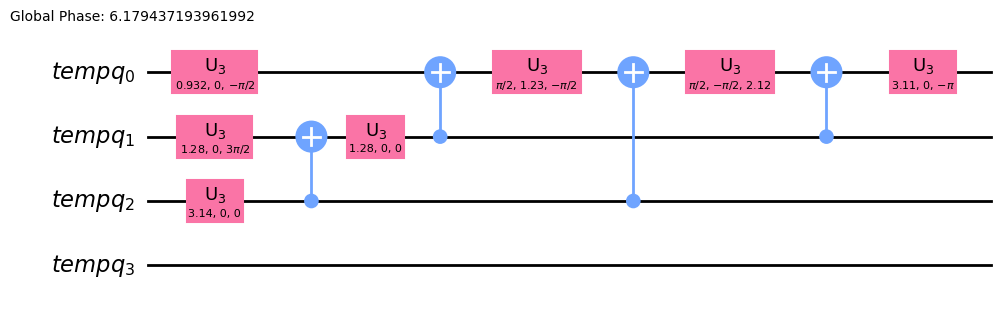

In [6]:
nqubits=4
tempq=QuantumRegister(nqubits,'tempq')
tempqc = QuantumCircuit(tempq)
B = [0.4,1,2,3,4,5,500000,1]
B /= np.linalg.norm(B)
tempqc.isometry(B,[0,1,2],[])
tempqc = transpile(tempqc, basis_gates=['u3','cx'], optimization_level=3)
tempqc.draw("mpl")

## Write local had test that will be run on every l, lp, j

In [277]:
def local_had_test(params, ansatz_circ, A, B, l, lp, j):
    '''
    Inputs:
    type ansatz_circ: qiskit circuit object, ansatz circuit, n registers
    type l: int
    type lp: int
    type j: int
    type A: list(string) decomposed A matrix
    type B: np array. normalized.
    type nqubits: number of qubits not including ancilla
    rtype: (int, qiskit circuit), int -> expexted value of test; circ -> final circuit of H test
    '''
    qr = QuantumRegister(ansatz_circ.num_qubits, 'q')
    anc = QuantumRegister(1, 'anc') #add ancilla register
    _circ = QuantumCircuit(qr)
    
    _circ.add_register(anc)
    _circ.initialize([1,0], anc)
    
    bound_ansatz = ansatz_circ.assign_parameters(dict(zip(ansatz_circ.parameters, params)))
    ansatz_inst = bound_ansatz.to_instruction(label='V(w)')
    _circ.append(ansatz_inst, qargs=_circ.qubits[0:-1]) 
    
    
    _circ.barrier()  
   
    #apply hadamard gate on ancilla
    _circ.h(anc) 

    
    #apply A_l to all qubits, control on ancilla
    U=A[l]
    CU=PauliGate(U).control(1)
    _circ.append(CU,qargs=[anc]+_circ.qubits[0:-1])

    
    qr = QuantumRegister(ansatz_circ.num_qubits, 'q')
    Udg_circ = QuantumCircuit(qr)
    Udg_circ.isometry (B, _circ.qubits[0:-1], [])
    Udg_circ = transpile (Udg_circ, basis_gates = ['u3', 'cx'], optimization_level=3)
    sub_inst = Udg_circ.to_instruction(label='U')
    
    _circ.append(sub_inst.inverse(), qargs=_circ.qubits[0:-1])
    
    
    if j != -1:
        _circ.cz(anc, _circ.qubits[j])
    
    
    _circ.append(sub_inst, qargs=_circ.qubits[0:-1])
    
    
    #apply A_lp, control on ancilla
    U=A[lp]
    CU=PauliGate(U).control(1).inverse()
    _circ.append(CU,qargs=[anc]+_circ.qubits[0:-1])
    
  
    #apply H to ancilla
    _circ.barrier()
    _circ.h(anc)
    
    '''
             ---                                                  ---
    |0>_anc -|H|-------------•---------------•--------------•-----|H|-
             ---             |               |              |     ---
                  ------   ------   -----    |    ----   ------
    |0>_0   ------|    |---|    |---|   |---------|  |---|    |-------
    .             |    |   |    |   |   |    |    |  |   |    |
    .             |V(w)|   |A_l |   |U^†|--|Z_j|--|U |   |A_lp|
    .             |    |   |    |   |   |  -----  |  |   |    |
    |0>_n-1 ------|    |---|    |---|   |---------|  |---|    |-------
                  ------   ------   -----         ----   ------
    '''  
    
    
    
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(_circ, simulator).result()
    statevector = result.get_statevector(_circ)
    
    q_inds = [i for i in range(ansatz_circ.num_qubits)]
    reduced_denmat = partial_trace(statevector, q_inds)
    
    
    prob_1 = np.real(reduced_denmat.data[1, 1])

    expectation = 1-(2*prob_1)  

    return expectation, _circ

### test local had test and compare to analytically computed results
#### Be careful using these tests. Must manually change to fit with specific had test params.

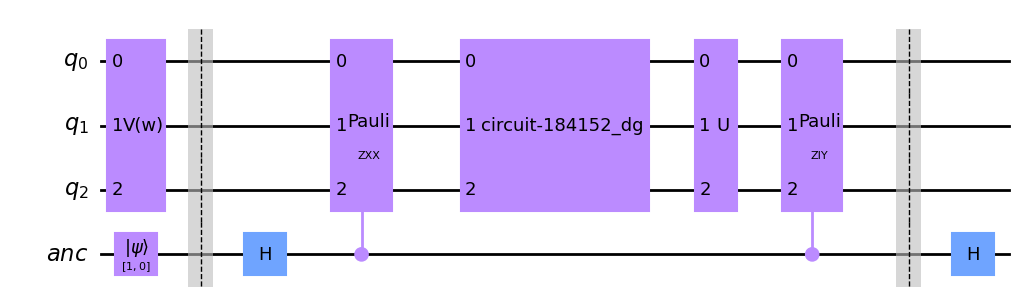

In [298]:
nqubits = 3
qr = QuantumRegister(nqubits, 'q')
qc = QuantumCircuit(qr)

#B= np.array([float(random.randint(0,3000))/1000 for i in range(2**nqubits)], dtype=float)
B= np.ones(2**nqubits)
B /= np.linalg.norm(B)


myansatz = RealAmplitudes(nqubits)
myansatz = fixedStructureAnsatz(qc,[i for i in range(nqubits)])  
dummyparams=[float(random.randint(0,3000))/1000 for i in range(len(myansatz.parameters))]


[val, hdT]=local_had_test(dummyparams, myansatz, ['ZIY', 'ZXX'],B, 1, 0, -1)
hdT.draw('mpl')

In [299]:
val

-2.220446049250313e-16

In [300]:
#analytically compute expected val and compare results
Paulis=['IIY', 'III']
nqubits=len(Paulis[0])

A_0=PauliGate(Paulis[1]).to_matrix()
A_1=PauliGate(Paulis[0]).inverse().to_matrix()

temp=QuantumRegister(nqubits,'tempq')
temp = QuantumCircuit(temp)
temp.z(1)
Z_0=Operator(temp).to_matrix()

V=Operator(myansatz.assign_parameters(dict(zip(myansatz.parameters, dummyparams)))).to_matrix()
V_dg=np.linalg.inv(V)

qr = QuantumRegister(myansatz.num_qubits, 'q')
#qr = QuantumRegister(qc.num_qubits, 'q')

Udg_circ = QuantumCircuit(qr)
Udg_circ.isometry (B, Udg_circ.qubits, [])
Udg_circ = transpile (Udg_circ, basis_gates = ['u3', 'cx'], optimization_level=3)
U=Operator(Udg_circ).to_matrix()
U_dg=np.linalg.inv(U)

zerovec=np.array([1]+[0 for i in range(2**len(Paulis[0])-1)])

# <0| V_dg A' U Z_j U_dg A V|0>

x=V@zerovec
prod = A_0@x
#prod = U_dg@prod
#prod = Z_0@prod
#prod = U@prod
prod = A_1@prod
expec=np.real(np.vdot(x, prod))

print('analytically computed val: ', expec)
print('had test val:', val)

error = 'nan'
if np.real(expec):
    error=((expec-val)/expec)*100
    
print("error(%) = ", error)

analytically computed val:  0.0
had test val: -2.220446049250313e-16
error(%) =  nan


## Local Cost Function:
### $C_L=\frac{1}{2}-\frac{1}{2n}\frac{\sum_{j=0}^{n-1}\sum_{l,l'}^{}c_lc_{l'}^*\mu_{l,l',j}}{\sum_{l,l'}^{}c_lc_{l'}^*\mu_{l,l',-1}}$

In [271]:
def psi_norm(params):
    '''
    Inputs:
    type ansatz_circ: qiskit circuit object, ansatz circuit, n registers
    type A: list(string) decomposed A matrix
    type B: np array. normalized.
    type c: list(int) coeff of decomposed A
    type nqubits: number of qubits not including ancilla
    rtype: float , <¥|¥>
    '''
    norm = 0.0
    
    for l in range(len(c)):
        for lp in range(len(c)):
            norm += c[l] * c[lp] * local_had_test(params, ansatz_circ, A, B, l, lp, -1)[0]
    
    return abs(norm)

In [272]:
def cost_loc(params):
    '''
    Inputs:
    type ansatz_circ: qiskit circuit object, ansatz circuit, n registers
    type A: list(string) decomposed A matrix
    type B: np array. normalized.
    type c: list(float) coeff of decomposed A
    type nqubits: number of qubits not including ancilla
    rtype: float 
    '''
    mu_sum = 0.0

    for l in range(len(c)):
        for lp in range(len(c)):
            for j in range(ansatz_circ.num_qubits):
                mu_sum += c[l] * c[lp] * local_had_test(params, ansatz_circ, A, B, l, lp, j)[0]

    mu_sum = abs(mu_sum)
    
    cost = 0.5 - 0.5 * mu_sum / (ansatz_circ.num_qubits * psi_norm(params))
    
    print("Cost_L = {:9.7f}".format(cost))
    cost_history.append(cost)
    
    return cost

# Running Test Cases

## Test case #1

### using fixedStructureAnsatz

In [283]:
nqubits=3
qr = QuantumRegister(nqubits, 'q')

ansatz_circ = QuantumCircuit(qr)
ansatz_circ = fixedStructureAnsatz(ansatz_circ,[i for i in range(nqubits)])

x0=[float(random.randint(0,3000))/1000 for i in range(len(ansatz_circ.parameters))]
print(x0)

B = np.ones(2**nqubits)
B /= np.linalg.norm(B)

A = ['ZIX']

c = [1]


[0.049, 2.798, 2.497, 0.289, 2.323, 0.583, 1.089, 2.394, 2.075, 0.582, 0.385, 2.061, 0.502, 0.362, 2.482]


In [286]:
cost_history = []
out = minimize(cost_loc, x0, method="COBYLA", options={'maxiter':200})
print(out)

Cost_L = 0.4852914
Cost_L = 0.3342570
Cost_L = 0.4488983
Cost_L = 0.3720985
Cost_L = 0.4592906
Cost_L = 0.3727089
Cost_L = 0.3944265
Cost_L = 0.3932005
Cost_L = 0.4430943
Cost_L = 0.3362131
Cost_L = 0.4788045
Cost_L = 0.4520388
Cost_L = 0.3210337
Cost_L = 0.2422235
Cost_L = 0.3220886
Cost_L = 0.3786906
Cost_L = 0.3403972
Cost_L = 0.1965218
Cost_L = 0.2334612
Cost_L = 0.1785251
Cost_L = 0.1782936
Cost_L = 0.1832349
Cost_L = 0.2121398
Cost_L = 0.1851092
Cost_L = 0.1955183
Cost_L = 0.1902523
Cost_L = 0.1964231
Cost_L = 0.1132123
Cost_L = 0.1236211
Cost_L = 0.1422139
Cost_L = 0.0973128
Cost_L = 0.1041779
Cost_L = 0.1021196
Cost_L = 0.1124942
Cost_L = 0.0940969
Cost_L = 0.0852528
Cost_L = 0.0950475
Cost_L = 0.0834681
Cost_L = 0.0734133
Cost_L = 0.0745800
Cost_L = 0.0675101
Cost_L = 0.0757304
Cost_L = 0.0687835
Cost_L = 0.0793479
Cost_L = 0.0607930
Cost_L = 0.0496900
Cost_L = 0.0403207
Cost_L = 0.0241473
Cost_L = 0.0410613
Cost_L = 0.0238918
Cost_L = 0.0348066
Cost_L = 0.0243011
Cost_L = 0.0

In [287]:
print(out['x'])
x_fsa = out['x']

[ 0.86610767  2.52594362  3.25419761  1.04876473  2.39897499  0.09277978
  0.31685491  2.13312674  2.13722764  0.36024953  0.37932438  3.33304059
  1.78251421 -0.18446395  1.7022956 ]


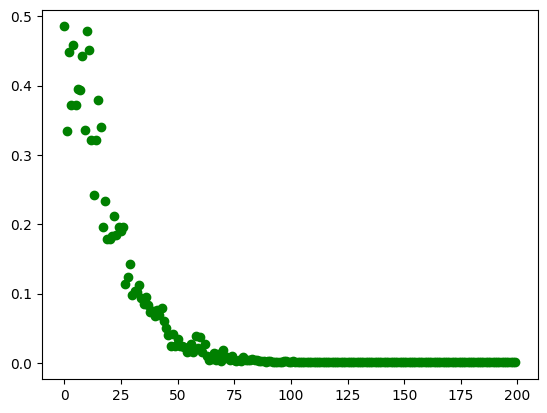

In [288]:
x = np.arange(0,len(cost_history),1)
plt.scatter(x,cost_history, color="g")
plt.show()

### using RealAmplitudes

In [289]:
nqubits=3
qr = QuantumRegister(nqubits, 'q')

ansatz_circ = QuantumCircuit(qr)
ansatz_circ = RealAmplitudes(nqubits)

x0=[float(random.randint(0,3000))/1000 for i in range(len(ansatz_circ.parameters))]
print(x0)

B = np.ones(2**nqubits)
B /= np.linalg.norm(B)

A = ['ZIX']

c = [1]

[1.568, 0.806, 1.067, 0.599, 2.837, 1.553, 2.275, 1.23, 1.924, 1.092, 2.891, 2.888]


In [290]:
cost_history = []
out = minimize(cost_loc, x0, method="COBYLA", options={'maxiter':200})
print(out)

Cost_L = 0.4915509
Cost_L = 0.4442719
Cost_L = 0.4150996
Cost_L = 0.3433713
Cost_L = 0.2745872
Cost_L = 0.2149046
Cost_L = 0.3868479
Cost_L = 0.4115089
Cost_L = 0.4233582
Cost_L = 0.2857545
Cost_L = 0.4238725
Cost_L = 0.4230626
Cost_L = 0.2734063
Cost_L = 0.1166134
Cost_L = 0.1854524
Cost_L = 0.1376529
Cost_L = 0.1585545
Cost_L = 0.1928900
Cost_L = 0.2664941
Cost_L = 0.1620310
Cost_L = 0.2925085
Cost_L = 0.1271809
Cost_L = 0.1065899
Cost_L = 0.1173427
Cost_L = 0.0619516
Cost_L = 0.0702388
Cost_L = 0.0465670
Cost_L = 0.0309297
Cost_L = 0.0278468
Cost_L = 0.0413934
Cost_L = 0.0336639
Cost_L = 0.0165281
Cost_L = 0.0317584
Cost_L = 0.0332225
Cost_L = 0.0353604
Cost_L = 0.0179984
Cost_L = 0.0136783
Cost_L = 0.0126834
Cost_L = 0.0046472
Cost_L = 0.0200637
Cost_L = 0.0115019
Cost_L = 0.0219002
Cost_L = 0.0057926
Cost_L = 0.0103778
Cost_L = 0.0043443
Cost_L = 0.0083889
Cost_L = 0.0056933
Cost_L = 0.0068327
Cost_L = 0.0047590
Cost_L = 0.0047588
Cost_L = 0.0079808
Cost_L = 0.0061528
Cost_L = 0.0

In [291]:
print(out['x'])
x_ra = out['x']

[2.29722288 1.94572784 2.51375669 1.54266869 4.69691851 1.30055684
 2.09937751 1.14576339 2.0307639  0.53484434 2.74242577 3.14919843]


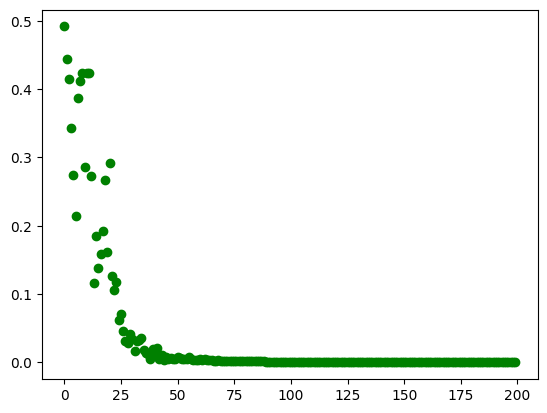

In [292]:
x = np.arange(0,len(cost_history),1)
plt.scatter(x,cost_history, color="g")
plt.show()

### Verifying results for test case #1

In [293]:
zerovec=np.array([1]+[0 for i in range(2**len(A[0])-1)])

In [294]:
#using fixedStructureAnsatz

qr = QuantumRegister(nqubits, 'q')
temp1 = QuantumCircuit(qr)
temp1 = fixedStructureAnsatz(temp1,[i for i in range(nqubits)])
V1=Operator(temp1.bind_parameters(dict(zip(temp1.parameters, x_fsa)))).to_matrix()

x_pos1 = np.real(V1@zerovec)
x_pos1

array([ 0.35507909,  0.36069624,  0.36423921,  0.34261139, -0.35577515,
       -0.34519443, -0.33890436, -0.36492873])

In [295]:
#using RealAmplitudes

qr = QuantumRegister(nqubits, 'q')
temp2 = QuantumCircuit(qr)
temp2 = RealAmplitudes(nqubits)
V2=Operator(temp2.bind_parameters(dict(zip(temp2.parameters, x_ra)))).to_matrix()

x_pos2 = np.real(V2@zerovec)
x_pos2

array([-0.35309193,  0.35121115,  0.35536141, -0.35181173, -0.35504451,
        0.35592905,  0.35095311, -0.35498369])

In [297]:
A_mat=PauliGate(A[0]).to_matrix()

print('original |b>:\n', B)
print('|b> using x_fsa:\n',np.real(A_mat@x_pos1))
print('|b> using x_ra:\n',np.real(A_mat@x_pos2))

original |b>:
 [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
|b> using x_fsa:
 [0.36069624 0.35507909 0.34261139 0.36423921 0.34519443 0.35577515
 0.36492873 0.33890436]
|b> using x_ra:
 [ 0.35121115 -0.35309193 -0.35181173  0.35536141 -0.35592905  0.35504451
  0.35498369 -0.35095311]


## Test Case #2

In [301]:
nqubits=3
qr = QuantumRegister(nqubits, 'q')

ansatz_circ = QuantumCircuit(qr)
ansatz_circ = RealAmplitudes(nqubits)

x0=[float(random.randint(0,3000))/1000 for i in range(len(ansatz_circ.parameters))]
print(x0)

B = np.ones(2**nqubits)
B /= np.linalg.norm(B)

A = ['IIZ', 'III']

c = [0.45,0.55]

[2.337, 1.53, 0.482, 0.126, 0.156, 0.569, 1.582, 1.896, 2.608, 1.549, 0.659, 1.49]


In [302]:
cost_history = []
out = minimize(cost_loc, x0, method="COBYLA", options={'maxiter':200})
print(out)

Cost_L = 0.3716942
Cost_L = 0.3896890
Cost_L = 0.3882312
Cost_L = 0.3551275
Cost_L = 0.3946574
Cost_L = 0.3753452
Cost_L = 0.3353949
Cost_L = 0.3226949
Cost_L = 0.3214761
Cost_L = 0.3771128
Cost_L = 0.2727260
Cost_L = 0.4123331
Cost_L = 0.2834440


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

## Test Case #3

In [845]:
nqubits=3
qr = QuantumRegister(nqubits, 'q')

ansatz_circ = QuantumCircuit(qr)
ansatz_circ = RealAmplitudes(nqubits)

x0=[float(random.randint(0,3000))/1000 for i in range(len(ansatz_circ.parameters))]
print(x0)

B = np.ones(2**nqubits)
B /= np.linalg.norm(B)

A = ['IIZ', 'IZI', 'IIZ']

c = [0.55,0.225,0.225]

[1.088, 2.07, 2.109, 0.622, 2.073, 2.967, 1.601, 0.25, 1.834, 0.477, 2.79, 2.504]


In [ ]:
cost_history = []
out = minimize(cost_loc, x0, method="COBYLA", options={'maxiter':200})
print(out)

In [ ]:
print(out['x'])

In [ ]:
x = np.arange(0,len(cost_history),1)
plt.scatter(x,cost_history, color="g")
plt.show()